# DATA_608_Module_02
Md. Jalal Uddin

In [3]:
import datashader as ds
import datashader.transfer_functions as tf
import datashader.glyphs
from datashader import reductions
from datashader.core import bypixel
from datashader.utils import lnglat_to_meters as webm, export_image
from datashader.colors import colormap_select, Greys9, viridis, inferno
import copy


from pyproj import Proj, transform
import numpy as np
import pandas as pd
import urllib
import json
import datetime
import colorlover as cl

import plotly
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

from shapely.geometry import Point, Polygon, shape
# In order to get shapley, you'll need to run [pip install shapely.geometry] from your terminal

from functools import partial

from IPython.display import GeoJSON
init_notebook_mode(connected=True)


C:\ProgramData\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\ProgramData\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [4]:
bk = pd.read_csv('C:/Users/sql_ent_svc/Desktop/Data_608/Module_2/Brooklyn.csv', low_memory=False)
bx = pd.read_csv('C:/Users/sql_ent_svc/Desktop/Data_608/Module_2/Bronx.csv', low_memory=False)
mn = pd.read_csv('C:/Users/sql_ent_svc/Desktop/Data_608/Module_2/Manhattan.csv', low_memory=False)
qn = pd.read_csv('C:/Users/sql_ent_svc/Desktop/Data_608/Module_2/Queens.csv', low_memory=False)
si = pd.read_csv('C:/Users/sql_ent_svc/Desktop/Data_608/Module_2/Staten_Island.csv', low_memory=False)


ny = pd.concat([bk, bx, mn, qn, si], ignore_index=True)

# Getting rid of some outliers
ny = ny[(ny['YearBuilt'] > 1850) & (ny['YearBuilt'] < 2020) & (ny['NumFloors'] != 0)]

In [5]:
wgs84 = Proj("+proj=longlat +ellps=GRS80 +datum=NAD83 +no_defs")
nyli = Proj("+proj=lcc +lat_1=40.66666666666666 +lat_2=41.03333333333333 +lat_0=40.16666666666666 +lon_0=-74 +x_0=300000 +y_0=0 +ellps=GRS80 +datum=NAD83 +to_meter=0.3048006096012192 +no_defs")
ny['XCoord'] = 0.3048*ny['XCoord']
ny['YCoord'] = 0.3048*ny['YCoord']
ny['lon'], ny['lat'] = transform(nyli, wgs84, ny['XCoord'].values, ny['YCoord'].values)

ny = ny[(ny['lon'] < -60) & (ny['lon'] > -100) & (ny['lat'] < 60) & (ny['lat'] > 20)]

#Defining some helper functions for DataShader
background = "black"
export = partial(export_image, background = background, export_path="export")
cm = partial(colormap_select, reverse=(background!="black"))

Part 1: Binning and Aggregation:
Binning is a common strategy for visualizing large datasets. Binning is inherent to a few types of visualizations, such as histograms and 2D histograms (also check out their close relatives: 2D density plots and the more general form: heatmaps.

While these visualization types explicitly include binning, any type of visualization used with aggregated data can be looked at in the same way. For example, lets say we wanted to look at building construction over time. This would be best viewed as a line graph, but we can still think of our results as being binned by year:

In [6]:
trace = go.Scatter(
    # I'm choosing BBL here because I know it's a unique key.
    x = ny.groupby('YearBuilt').count()['BBL'].index,
    y = ny.groupby('YearBuilt').count()['BBL']
)

layout = go.Layout(
    xaxis = dict(title = 'Year Built'),
    yaxis = dict(title = 'Number of Lots Built')
)

fig = go.Figure(data = [trace], layout = layout)

#py.iplot(fig, filename = 'ny-year-built')
plotly.offline.iplot(fig)

In [7]:
# Start your answer here, inserting more cells as you go along
ny_yearfloor = ny.groupby(['YearBuilt','NumFloors'], as_index=False).agg({"NumBldgs": "sum"})

ny_yearfloor.sample(25)

,YearBuilt,NumFloors,NumBldgs
1953,1958.0,1.67,8.0
357,1902.0,1.00,5.0
2517,1973.0,14.00,11.0
607,1912.0,3.50,4.0
2318,1968.0,11.00,4.0
579,1911.0,2.00,80.0
3411,2000.0,54.00,1.0
1560,1942.0,2.50,7.0
3138,1990.0,43.00,1.0
2567,1974.0,30.00,2.0


In [8]:

trace = go.Heatmap(z=np.array((ny_yearfloor['NumBldgs'])),
                   x=np.array((ny_yearfloor['YearBuilt'])),
                   y=np.array((ny_yearfloor['NumFloors'])))

layout = go.Layout(
    title='Number of Buildings',
    xaxis = dict(title = 'Year Built'),
    yaxis = dict(title = 'Number Floors')
)

fig = go.Figure(data = [trace], layout = layout)

#py.iplot(fig, filename = 'ny-year-built')
plotly.offline.iplot(fig)

In [9]:
def FloorRange(NumFloors):
    rangeVal = ''
    if NumFloors > 0 and NumFloors < 10:
        rangeVal = '1 - 9'
    elif NumFloors >= 10 and NumFloors < 20:
        rangeVal = '10 - 19'
    elif NumFloors >= 20 and NumFloors < 30:
        rangeVal = '20 - 29'
    elif NumFloors >= 30 and NumFloors < 40:
        rangeVal = '30 - 39'
    elif NumFloors >= 40 and NumFloors < 50:
        rangeVal = '40 - 49'
    elif NumFloors >= 50 and NumFloors < 60:
        rangeVal = '50 - 59'
    elif NumFloors >= 60 and NumFloors < 70:
        rangeVal = '60 - 69'
    elif NumFloors >= 70 and NumFloors < 80:
        rangeVal = '70 - 79'
    elif NumFloors >= 80 and NumFloors < 90:
        rangeVal = '80 - 89'
    elif NumFloors >= 90 and NumFloors < 100:
        rangeVal = '90 - 99'
    elif NumFloors >= 100 and NumFloors < 110:
        rangeVal = '100 - 109'
    elif NumFloors >= 110 and NumFloors < 120:
        rangeVal = '110 - 119'
    else:
        rangeVal = '>121'
    return rangeVal


ny_yearfloor['FloorRange'] = ny_yearfloor.NumFloors.apply(FloorRange)

ny_yearfloorRange = ny_yearfloor.groupby(['YearBuilt','FloorRange'], as_index=False).agg({"NumBldgs": "sum"})
ny_yearfloorRange.sample(25)

,YearBuilt,FloorRange,NumBldgs
93,1910.0,1 - 9,58228.0
71,1902.0,10 - 19,18.0
270,1956.0,10 - 19,39.0
554,2007.0,50 - 59,1.0
552,2007.0,30 - 39,16.0
620,2016.0,70 - 79,1.0
197,1933.0,30 - 39,3.0
625,2017.0,40 - 49,3.0
609,2015.0,40 - 49,4.0
281,1958.0,40 - 49,1.0


In [10]:
trace = go.Heatmap(x=ny_yearfloorRange['YearBuilt'],
                   y=ny_yearfloorRange['FloorRange'],
                   z=ny_yearfloorRange['NumBldgs'])

layout = go.Layout(
    title='Number of Buildings',
    xaxis = dict(title = 'Year Built'),
    yaxis = dict(title = 'Floors')
)

fig = go.Figure(data = [trace], layout = layout)

#py.iplot(fig, filename = 'ny-year-built')
plotly.offline.iplot(fig)

In [11]:
yearbins = 200
floorbins = 200

yearBuiltCut = pd.cut(ny['YearBuilt'], np.linspace(ny['YearBuilt'].min(), ny['YearBuilt'].max(), yearbins))
numFloorsCut = pd.cut(ny['NumFloors'], np.logspace(1, np.log(ny['NumFloors'].max()), floorbins))

xlabels = np.floor(np.linspace(ny['YearBuilt'].min(), ny['YearBuilt'].max(), yearbins))
ylabels = np.floor(np.logspace(1, np.log(ny['NumFloors'].max()), floorbins))

data = [
    go.Heatmap(z = ny.groupby([numFloorsCut, yearBuiltCut])['BBL'].count().unstack().fillna(0).values,
              colorscale = 'Greens', x = xlabels, y = ylabels)
]

fig = go.Figure(data = data)

#py.iplot(data, filename = 'datashader-2d-hist')
plotly.offline.iplot(fig)

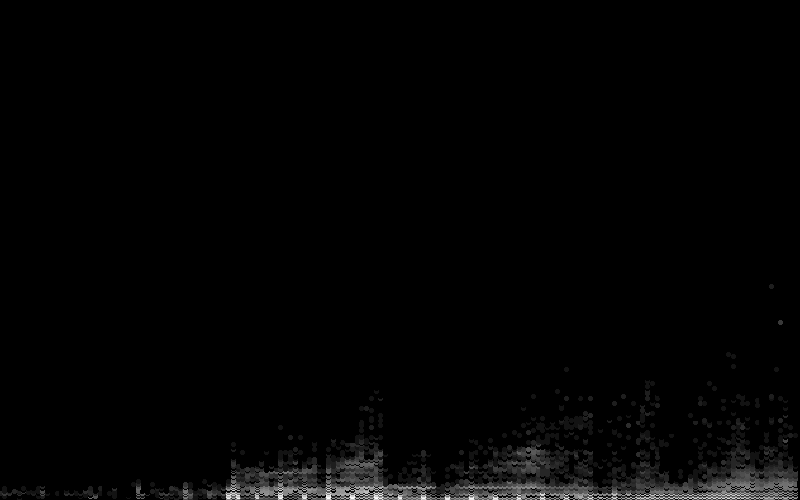

In [12]:
cvs = ds.Canvas(800, 500, x_range = (ny['YearBuilt'].min(), ny['YearBuilt'].max()), 
                                y_range = (ny['NumFloors'].min(), ny['NumFloors'].max()))
agg = cvs.points(ny, 'YearBuilt', 'NumFloors')
view = tf.shade(agg, cmap = cm(Greys9), how='log')
export(tf.spread(view, px=2), 'yearvsnumfloors')

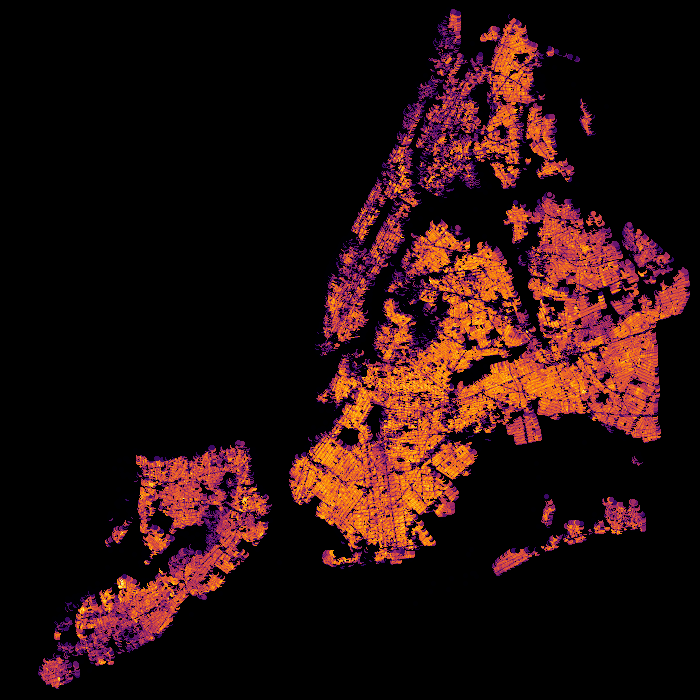

In [13]:
NewYorkCity   = (( -74.29,  -73.69), (40.49, 40.92))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(ny, 'lon', 'lat')
view = tf.shade(agg, cmap = cm(inferno), how='log')
export(tf.spread(view, px=2), 'firery')

In [14]:
ny['AssessStruct'] = ny['AssessTot'] - ny['AssessLand']

ny['AssessVal'] = ny['AssessLand']/ny['AssessStruct']


def AssessValue(AssessVal):
    rangeVal = ''
    if round(AssessVal,0) > 1:
        rangeVal = 'UnderBuilt'
    elif round(AssessVal,0) < 1:
        rangeVal = 'OverBuilt'
    else:
        rangeVal = 'Normal'
    return rangeVal

ny['Assessment'] = ny.AssessVal.apply(AssessValue)


nyAsses = ny.groupby(['Borough','ZipCode','Assessment'], as_index=False).agg({"BBL": "count"})
nyAsses.rename(columns={'BBL': 'AssessmentCount'}, inplace=True)

nyBoroughCount = ny.groupby(['Borough','ZipCode'], as_index=False).agg({"BBL": "count"})
nyBoroughCount.rename(columns={'BBL': 'ZipCountCount'}, inplace=True)

nyAsses = nyAsses.merge(nyBoroughCount, how='left')
nyAsses['Percentage'] = round(100 * nyAsses['AssessmentCount']/nyAsses['ZipCountCount'],2)

nyAsses.sample(25)

,Borough,ZipCode,Assessment,AssessmentCount,ZipCountCount,Percentage
555,SI,10306.0,Normal,5893,15312,38.49
540,SI,10301.0,Normal,4079,6923,58.92
544,SI,10302.0,OverBuilt,1519,4268,35.59
71,BK,11225.0,UnderBuilt,56,3809,1.47
429,QN,11370.0,OverBuilt,3876,4048,95.75
515,QN,11434.0,Normal,8394,10274,81.70
414,QN,11365.0,OverBuilt,2558,6289,40.67
347,MN,10282.0,UnderBuilt,1,17,5.88
494,QN,11426.0,Normal,3941,4388,89.81
412,QN,11364.0,UnderBuilt,23,5952,0.39


In [15]:
trace = go.Heatmap(x=nyAsses['ZipCode'],
                   y=nyAsses['Assessment'],
                   z=nyAsses['Percentage'], colorscale = 'Viridis',)

layout = go.Layout(
    title='ZipCode Vs. Assessment',
    xaxis = dict(title = 'ZipCode'),
    yaxis = dict(title = 'Assessment')
)

fig = go.Figure(data = [trace], layout = layout)

#py.iplot(fig, filename = 'ny-year-built')
plotly.offline.iplot(fig)